<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 8. Support Vector Machines: Implementación y comparación con otros modelos, sobre el dataset de banking</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>


## Clasificación con SVM: campaña del banco de Portugal

En este notebook retomamos el conjunto de datos utilizado previamente en la sección de **regresión logística**, que corresponde a una campaña de marketing telefónico de un banco portugués. El objetivo es predecir si un cliente aceptará (**sí**) o no (**no**) una oferta de depósito a plazo fijo, a partir de variables socioeconómicas, características de la llamada y del historial previo.

Ahora aplicaremos un modelo de **Máquinas de Vectores de Soporte (SVM)** para resolver este problema de **clasificación binaria**. SVM es un modelo particularmente útil para encontrar fronteras de decisión óptimas entre clases, especialmente en espacios de alta dimensión, y puede adaptarse tanto a separaciones lineales como no lineales mediante el uso de **kernels**.

El flujo de trabajo será igual al realizado cuando implementamos la regresión logística, pero haremos una **comparación explícita entre diferentes modelos de clasificación**, destacando fortalezas y limitaciones de cada uno.

In [15]:
# Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings

# Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

## Carga de datos

In [2]:
mainpath = "../data/"
filename = "banking/bank.csv"
fullpath = os.path.join(mainpath,filename)

df_bank = pd.read_csv(fullpath, sep=';') # la separación de este csv es ;
#df_bank = pd.read_csv(fullpath)
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

## Preprocesamiento de datos

In [3]:
# Transformar la variable objetivo a valor numérico 1 ó 0
df_bank['y'] = df_bank['y'].map({'yes': 1, 'no': 0})
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


#### Procesamiento de la variable `education`

In [4]:
# tenemos mucha informacion (sobre todo de educacion basica), está muy segmentado
## podemos agrupar esta educación básica y hacerlo una sola categoría

df_bank['education'] = np.where(df_bank['education'] == "basic.4y", "Basic", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "basic.6y", "Basic", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "basic.9y", "Basic", df_bank["education"])

## checar que la variable sea educacion basica y renombrarla como "Basic"
# en caso contrario quedarse con la información de df_bank["education"] sin modificar

# para las demas

df_bank['education'] = np.where(df_bank['education'] == "high.school", "High School", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "professional.course", "Professional Course", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "university.degree", "University Degree", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "illiterate", "Illiterate", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "unknown", "Unknown", df_bank["education"])

In [8]:
# Podemos hacer una separación entre variables categoricas y numericas del dataset
cat_cols = df_bank.select_dtypes(include='object').columns
num_cols = df_bank.select_dtypes(include='number').columns

## Codificación de variables categóricas

In [9]:
# Aplicamos codificación one-hot
df_bank_encoded = pd.get_dummies(df_bank, columns=cat_cols, drop_first=True, dtype=int)
df_bank_encoded.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,1,0,0,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,0,1,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0


## Matriz de Característica y variable objetivo

In [11]:
# Matriz de características X y variable objetivo y
X = df_bank_encoded.drop('y', axis=1) # todo menos y
y = df_bank_encoded['y']

## Selección de variables con RFE (Recursive Feature Elimination) y Validación Cruzada

En secciones anteriores habíamos utilizado **RFE (Recursive Feature Elimination)** para reducir dimensionalidad eliminando iterativamente las variables menos relevantes según un modelo base. Ahora complementaremos esa estrategia con **validación cruzada**, mediante `RFECV`, que no solo elimina variables en cada iteración, sino que además evalúa el desempeño del modelo con diferentes subconjuntos de variables utilizando **cross-validation**.

Esto nos permite determinar automáticamente el **número óptimo de características** que maximizan el rendimiento predictivo (por defecto medido con `accuracy`), evitando tanto el **uso excesivo de variables irrelevantes** como la pérdida de información útil. Además, `RFECV` puede ayudarnos a visualizar cómo cambia el desempeño en función del número de variables seleccionadas.

In [17]:
# Definimos el modelo base: regresión logística y semilla para reproducibilidad
estimator = LogisticRegression(random_state=15, max_iter=10000)

# Configuramos RFECV (Recursive Feature Elimination with Cross-Validation)
# Se utiliza validación cruzada estratificada con 5 particiones y aleatorización
rfecv = RFECV(estimator=estimator,
              cv=StratifiedKFold(5, random_state=17, shuffle=True),
              scoring="accuracy")  # Métrica de evaluación: exactitud

# Ajustamos el modelo a los datos
# Esto entrenará múltiples modelos eliminando características menos importantes,
# y seleccionará el subconjunto que maximice la exactitud promedio de validación
rfecv.fit(X, y)

/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

RFECV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
      estimator=LogisticRegression(max_iter=10000, random_state=15),
      scoring='accuracy')

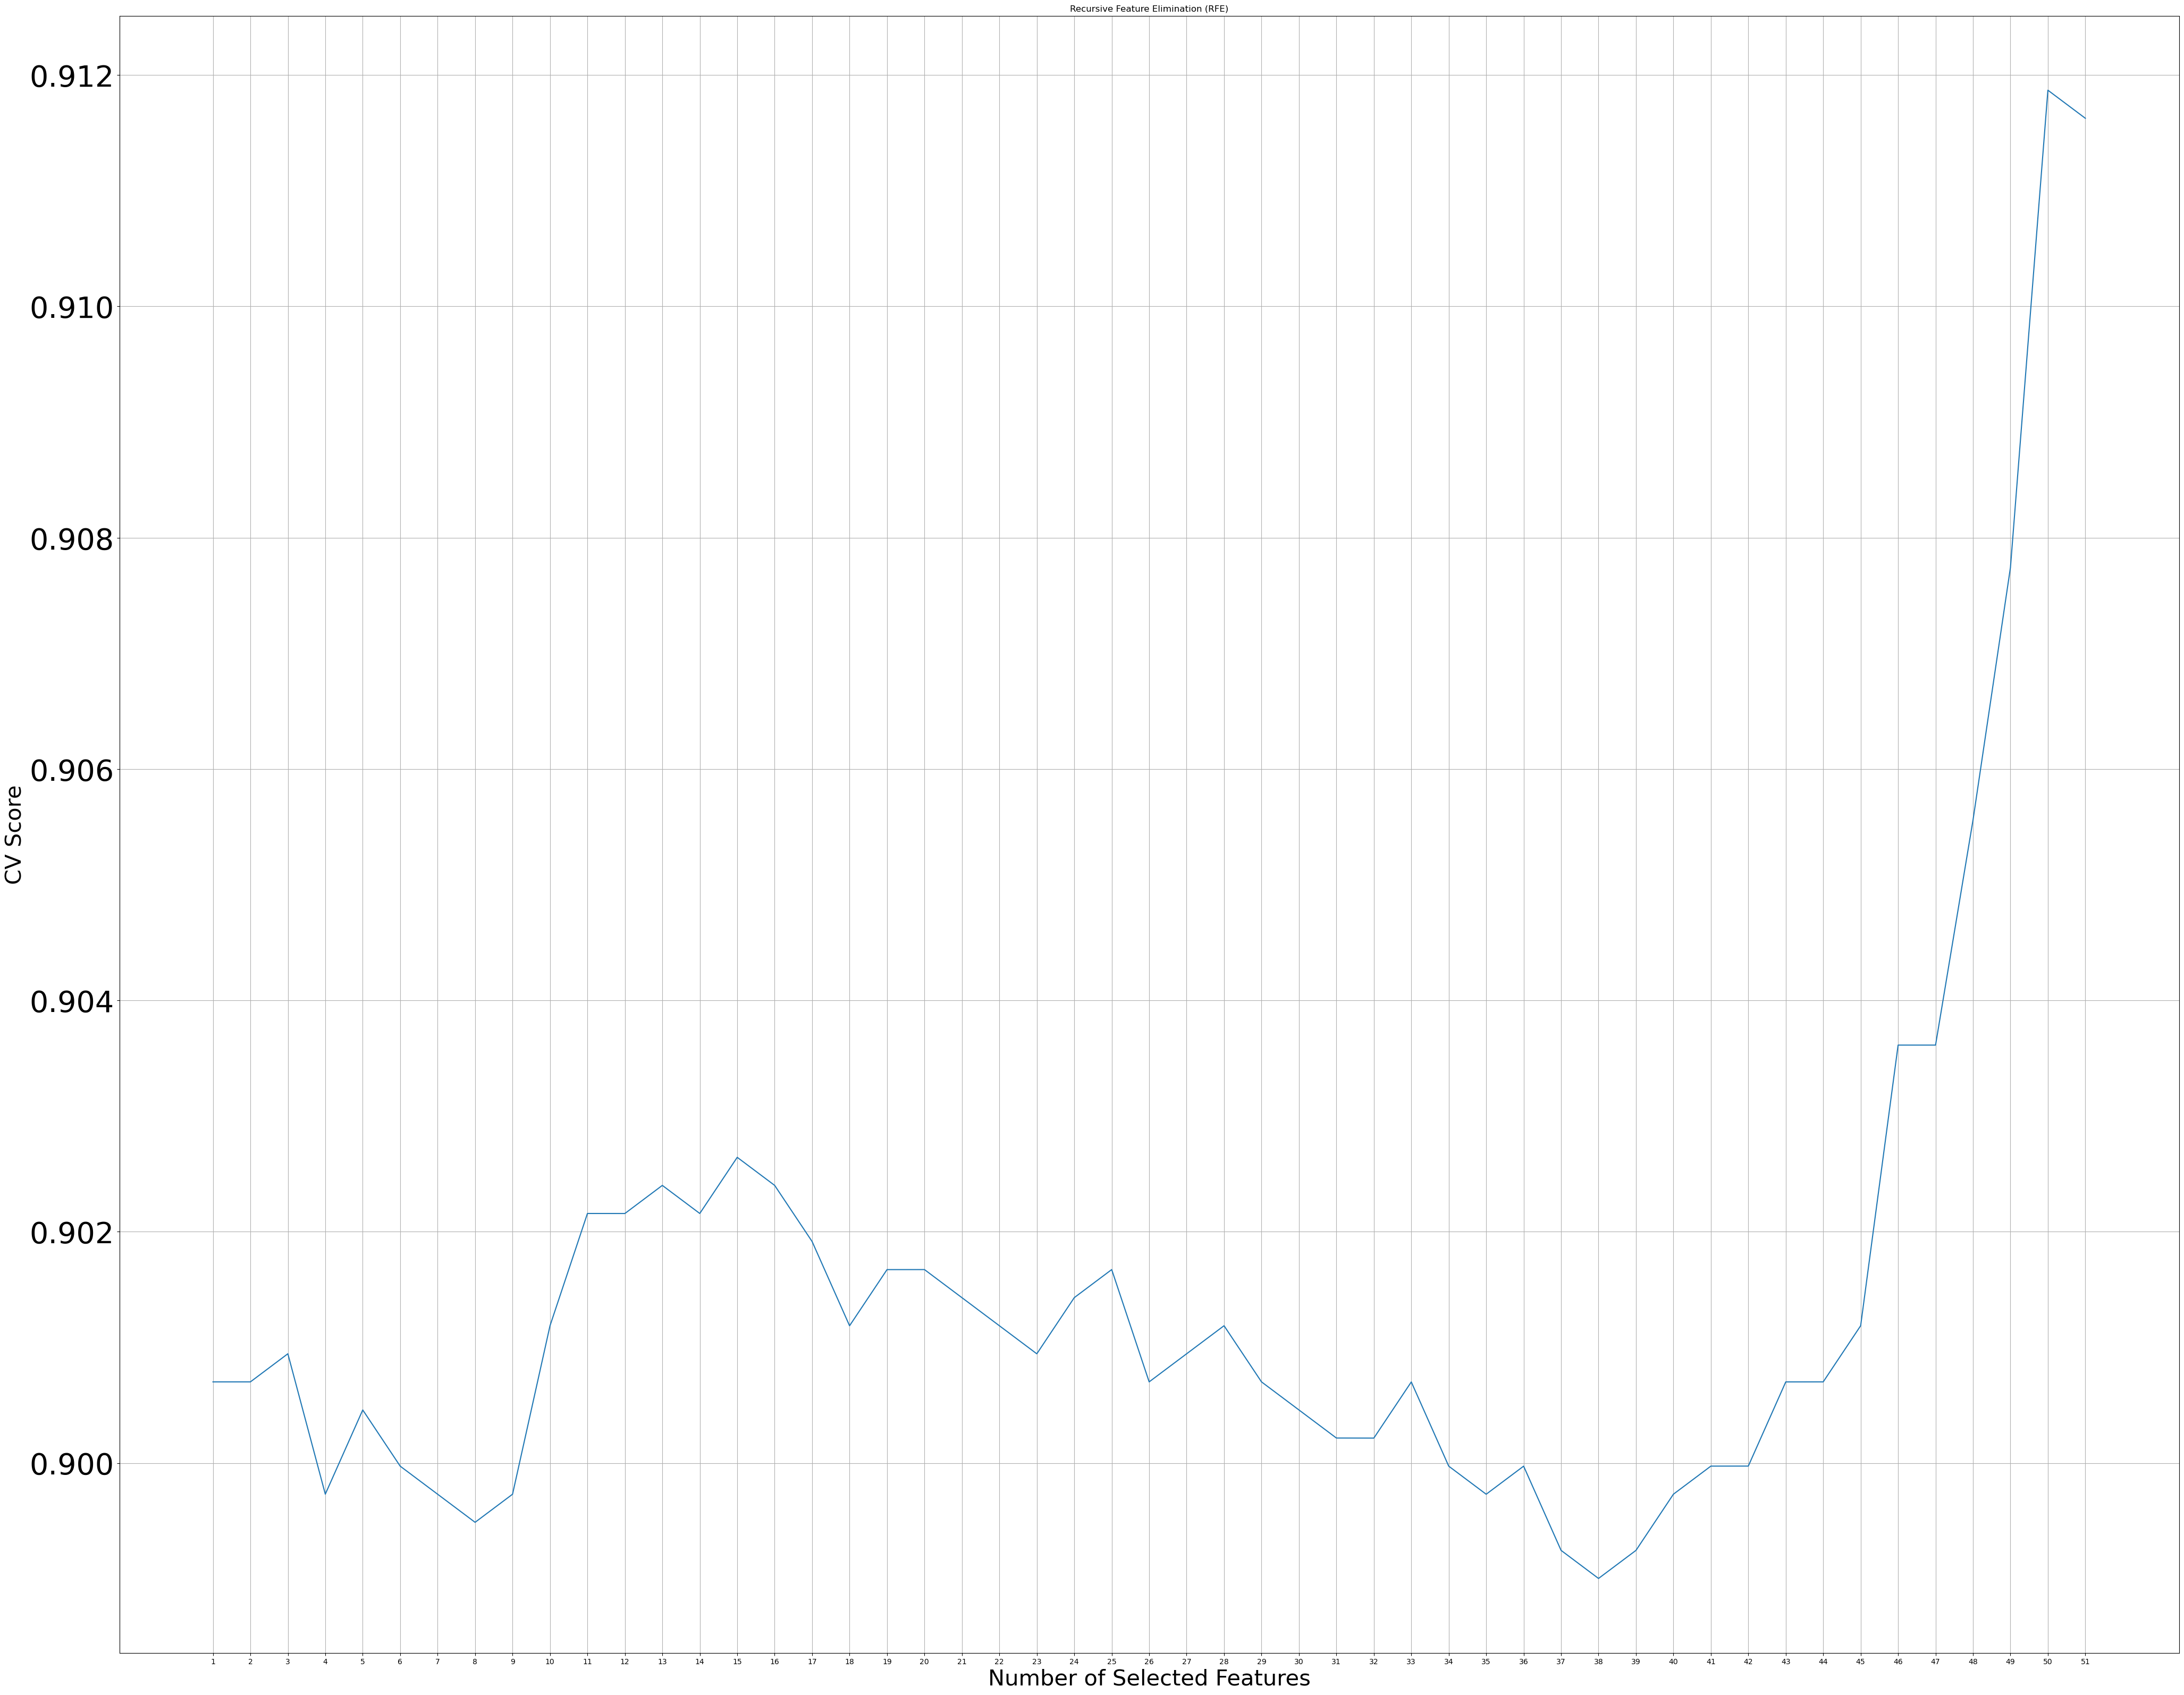

El número óptimo de features es: 50


In [20]:
plt.figure(figsize=(50, 40))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'])+1), rfecv.cv_results_['mean_test_score'])
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.yticks(size=40)
plt.xlabel("Number of Selected Features", size=30)
plt.ylabel("CV Score", size=30)
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("El número óptimo de features es: {}".format(rfecv.n_features_))

In [22]:
# podemos hacer una tabla para ver cuáles variables quedaron

# Crear un DataFrame con los resultados
rfe_results = pd.DataFrame({
    'Variable': X.columns,
    'Seleccionada': rfecv.support_,
    'Ranking': rfecv.ranking_
})

# Ordenar por ranking (1 = más importante)
rfe_results = rfe_results.sort_values(by='Ranking')

# Mostrar la tabla
rfe_results.style\
    .applymap(lambda val: 'background-color: lightgreen' if val == True else '', subset=['Seleccionada'])\
    .format({'Ranking': '{:.0f}'})

/var/folders/ls/3cpc9bjx04xfmf_tzhgzfgrm0000gn/T/ipykernel_91309/520176380.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  rfe_results.style\


,Variable,Seleccionada,Ranking
0,age,True,1
1,duration,True,1
2,campaign,True,1
4,previous,True,1
6,cons.price.idx,True,1
5,emp.var.rate,True,1
7,cons.conf.idx,True,1
8,euribor3m,True,1
12,job_housemaid,True,1
9,nr.employed,True,1


In [23]:
# Lista de nombres de variables seleccionadas
rfe_cols = X.columns[rfecv.support_].tolist()

# Mostrar la lista
print("Variables seleccionadas por RFE:")
print(rfe_cols)

Variables seleccionadas por RFE:
['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 'education_High School', 'education_Illiterate', 'education_Professional Course', 'education_University Degree', 'education_Unknown', 'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success']


In [24]:
## Con estas variable podemos volver a definir una matriz de características (para rfe)
X_rfe = df_bank_encoded[rfe_cols]

In [27]:
print(f'Dimensiones antes de RFE: {X.shape}') # 51 variables
print(f'Dimensiones después de RFE: {X_rfe.shape}') # 50 variables

Dimensiones antes de RFE: (4119, 51)
Dimensiones después de RFE: (4119, 50)


## Comparación de modelos ML

En esta sección entrenaremos y compararemos distintos algoritmos de **machine learning supervisado** para resolver el mismo problema de clasificación binaria sobre la campaña de marketing del banco de Portugal. Si bien en secciones anteriores trabajamos a profundidad con **regresión logística** y **árboles de decisión**, aquí introduciremos brevemente otros modelos comunes como:

- **SVM** (`SVM`)
- **Naive Bayes gaussiano** (`GaussianNB`)
- **Vecinos más cercanos (KNN)** (`KNeighborsClassifier`)

Aunque aún no hemos estudiado con detalle algunos de estos modelos, esta será una **buena oportunidad para ilustrar una práctica esencial en machine learning**: comparar varios algoritmos en el mismo conjunto de datos para identificar cuál se adapta mejor al problema, considerando tanto el desempeño como la complejidad y el tiempo de entrenamiento.

Evaluaremos los modelos usando métricas estándar como la **exactitud (accuracy)**, la **matriz de confusión**. Esta comparación inicial nos permitirá reflexionar sobre los **compromisos entre interpretabilidad, capacidad de generalización y comportamiento con clases desbalanceadas**.

> *Recordatorio: todos los modelos serán entrenados con el mismo conjunto de variables seleccionadas previamente mediante RFECV, y se usará la misma partición de entrenamiento y prueba para una comparación justa.*


In [29]:
# split de datos de entrenamiento y datos de validacion

X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test = train_test_split(X,
                                                            X_rfe,
                                                            y, 
                                                            train_size=0.8, 
                                                            stratify=y,
                                                            random_state=10)
print("Train size: {}".format(len(y_train)))
print("Test size: {}".format(len(y_test)))

Train size: 3295
Test size: 824


In [33]:
# Entrenamiento de varios modelos ML
random_state  = 13


clf_keys = ["Logistic Regression", "Support Vector Machine", "Naive Bayes", "k-Nearest Neighbors",
            "Decision Tree"]
clf_values = [LogisticRegression(random_state=random_state, max_iter=10000),
              SVC(kernel="linear", random_state=random_state),
              GaussianNB(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=random_state, min_samples_split=50,min_samples_leaf=20)]

clf_rfe_keys = ["Logistic Regression", "Support Vector Machine", "Naive Bayes", "k-Nearest Neighbors",
                "Decision Tree"]
clf_rfe_values = [LogisticRegression(random_state=random_state, max_iter=5000),
                  SVC(kernel="linear", random_state=random_state),
                  GaussianNB(),
                  KNeighborsClassifier(),
                  DecisionTreeClassifier(random_state=random_state, min_samples_split=50,min_samples_leaf=20)]



clfs = dict(zip(clf_keys, clf_values))
clfs_rfe = dict(zip(clf_rfe_keys, clf_rfe_values))

# Dataset original
print("Entrenamiento del modelo utilizando dataset original: comienza!")
for clf_name, clf in clfs.items():
    clf.fit(X_train, y_train)
    clfs[clf_name] = clf
    print(clf_name, ", entrenamiento: completado!")
print("Entrenamiento del modelo utilizando dataset original: termina!\n")

# Dataset con menos características (RFECV)
print("Entrenamiento del modelo utilizando RFE: comienza!")
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    clf_rfe.fit(X_rfe_train, y_train)
    clfs_rfe[clf_rfe_name] = clf_rfe
    print(clf_rfe_name, ", entrenamiento: completado!")
print("Entrenamiento del modelo utilizando RFE: termina!")

Entrenamiento del modelo utilizando dataset original: comienza!
Logistic Regression , entrenamiento: completado!
Support Vector Machine , entrenamiento: completado!
Naive Bayes , entrenamiento: completado!
k-Nearest Neighbors , entrenamiento: completado!
Decision Tree , entrenamiento: completado!
Entrenamiento del modelo utilizando dataset original: termina!

Entrenamiento del modelo utilizando RFE: comienza!


/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression , entrenamiento: completado!
Support Vector Machine , entrenamiento: completado!
Naive Bayes , entrenamiento: completado!
k-Nearest Neighbors , entrenamiento: completado!
Decision Tree , entrenamiento: completado!
Entrenamiento del modelo utilizando RFE: termina!


In [34]:
# Checamos la exactitud antes y después de RFE

# Dataset original
acc = []
for clf_name, clf in clfs.items():
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

# Dataset RFE
acc_rfe = []
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    y_rfe_pred = clf_rfe.predict(X_rfe_test)
    acc_rfe.append(accuracy_score(y_test, y_rfe_pred))
    
acc_all = pd.DataFrame({"Original dataset": acc, "Feature-selected dataset": acc_rfe},
                       index=clf_keys)
acc_all

,Original dataset,Feature-selected dataset
Logistic Regression,0.902913,0.904126
Support Vector Machine,0.900485,0.902913
Naive Bayes,0.861650,0.853155
k-Nearest Neighbors,0.901699,0.895631
Decision Tree,0.898058,0.900485


Accuracy
Original dataset            0.892961
Feature-selected dataset    0.891262


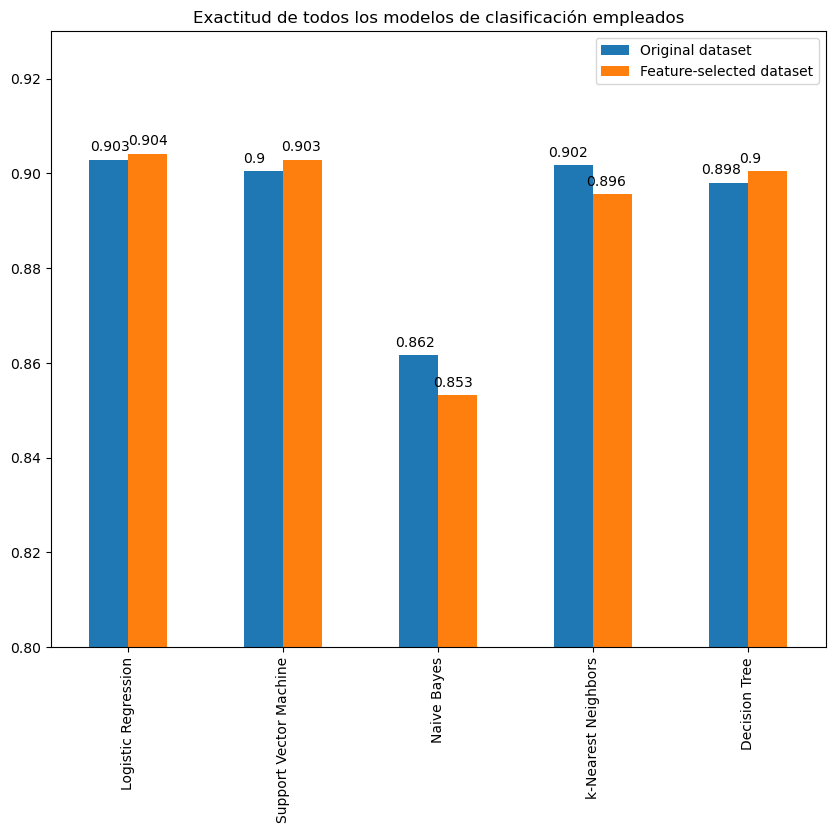

In [36]:
# Bar plot 

print("Accuracy\n" + acc_all.mean().to_string())

ax = acc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.002))
plt.ylim((0.8, 0.93))
plt.xticks(rotation=90)
plt.title("Exactitud de todos los modelos de clasificación empleados")
plt.show()

## Evaluación del Modelo

In [38]:
scoring = ["accuracy", "roc_auc"]
random_state=10

scores = []
# Original dataset
print("Validación cruzada sobre los datos originales: comienza!")
for clf_name, clf in clfs.items():
    score = pd.DataFrame(cross_validate(clf, X, y, cv=StratifiedKFold(5, random_state=random_state, shuffle=True), scoring=scoring)).mean()
    scores.append(score)
    print(clf_name, "validación cruzada: termina!")
cv_scores = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
print("Validación cruzada sobre los datos originales: termina!\n")

scores = []
# Feature-selected dataset
print("Validación cruzada sobre los datos después de RFE: comienza!")
for clf_name, clf in clfs_rfe.items():
    score = pd.DataFrame(cross_validate(clf, X_rfe, y, cv=StratifiedKFold(5, random_state=random_state, shuffle=True), scoring=scoring)).mean()
    scores.append(score)
    print(clf_name, "validación cruzada: termina!")
cv_scores_rfe = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
print("Validación cruzada sobre los datos después de RFE: termina!")

Validación cruzada sobre los datos originales: comienza!


/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Logistic Regression validación cruzada: termina!
Support Vector Machine validación cruzada: termina!
Naive Bayes validación cruzada: termina!
k-Nearest Neighbors validación cruzada: termina!
Decision Tree validación cruzada: termina!
Validación cruzada sobre los datos originales: termina!

Validación cruzada sobre los datos después de RFE: comienza!


/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Logistic Regression validación cruzada: termina!
Support Vector Machine validación cruzada: termina!
Naive Bayes validación cruzada: termina!
k-Nearest Neighbors validación cruzada: termina!
Decision Tree validación cruzada: termina!
Validación cruzada sobre los datos después de RFE: termina!


Cross-validation accuracy
Original data            0.89886
Feature-selected data    0.89517


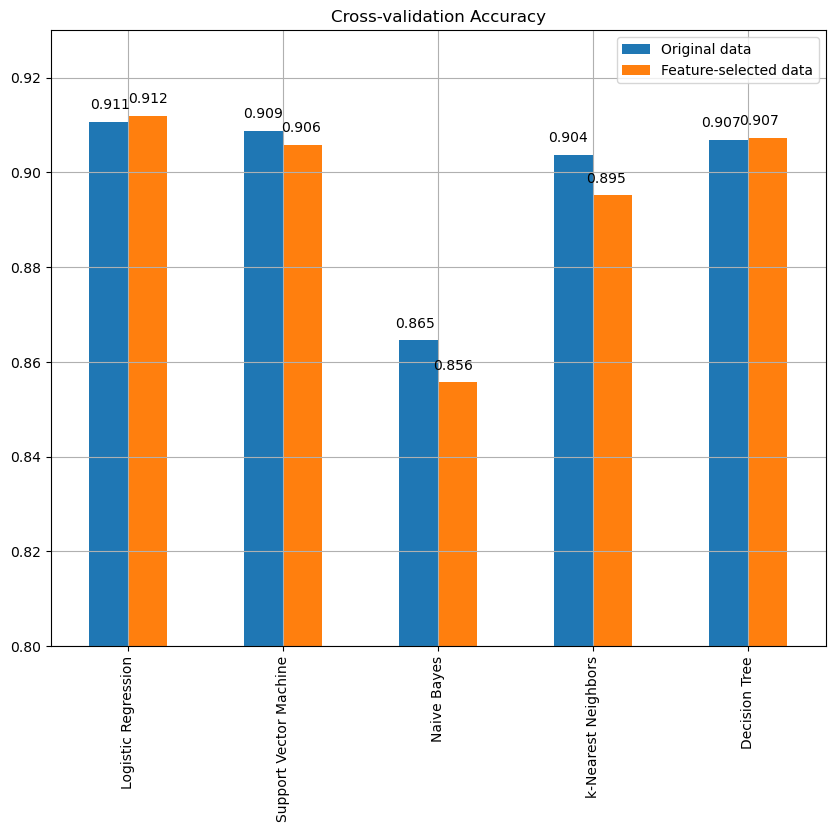

In [39]:
# Accuracy
cv_acc_all = pd.concat([cv_scores.loc["test_accuracy"].rename("Original data"), cv_scores_rfe.loc["test_accuracy"].rename("Feature-selected data")], 
                       axis=1)

print("Cross-validation accuracy\n" + cv_acc_all.mean().to_string())
ax = cv_acc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.ylim((0.8, 0.93))
plt.title("Cross-validation Accuracy")
plt.grid()
plt.legend()
plt.show()

Cross-validation ROC AUC score
Original data            0.883951
Feature-selected data    0.881526


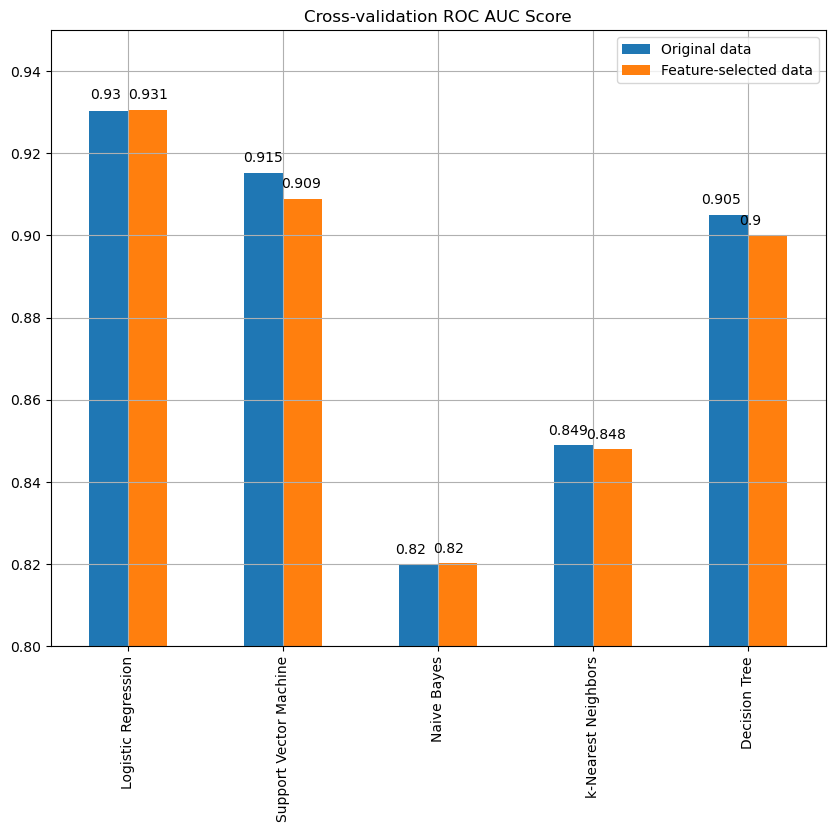

In [40]:
# ROC AUC
cv_roc_auc_all = pd.concat([cv_scores.loc["test_roc_auc"].rename("Original data"), cv_scores_rfe.loc["test_roc_auc"].rename("Feature-selected data")], 
                           axis=1)

print("Cross-validation ROC AUC score\n" + cv_roc_auc_all.mean().to_string())
ax = cv_roc_auc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.ylim((0.8, 0.95))
plt.title("Cross-validation ROC AUC Score")
plt.grid()
plt.legend()
plt.show()

Cross-validation fit time
Original data            1.763997
Feature-selected data    0.852593


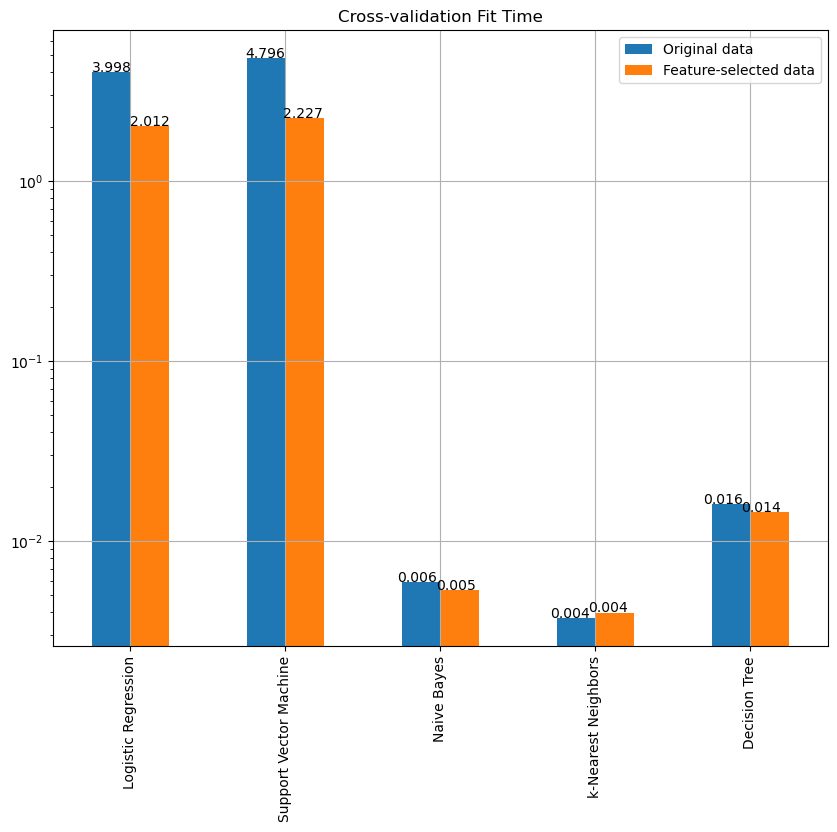

In [41]:
# Fit time
cv_fit_time_all = pd.concat([cv_scores.loc["fit_time"].rename("Original data"), cv_scores_rfe.loc["fit_time"].rename("Feature-selected data")], 
                           axis=1)

print("Cross-validation fit time\n" + cv_fit_time_all.mean().to_string())
ax = cv_fit_time_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Cross-validation Fit Time")
plt.grid()
plt.legend()
plt.show()

## Resumen y conclusiones

Tras aplicar **validación cruzada** a múltiples modelos de clasificación —regresión logística, árboles de decisión, SVM, Naive Bayes y KNN— evaluamos su desempeño utilizando métricas complementarias: **exactitud (accuracy)** para medir el porcentaje de predicciones correctas, **AUC (Área Bajo la Curva ROC)** para evaluar la discriminación entre clases, y el **tiempo de ejecución** para considerar su eficiencia computacional.

Los resultados muestran que **ningún modelo es universalmente superior** en todos los criterios: por ejemplo, mientras que SVM y regresión logística ofrecen buenos valores de AUC y generalización, KNN y árboles pueden ser más rápidos de entrenar, pero sensibles al sobreajuste o a la escala de los datos. Por su parte, Naive Bayes destaca por su velocidad, aunque puede subajustar si las hipótesis de independencia no se cumplen.

Esta comparación refuerza una lección clave en machine learning: **elegir un modelo implica considerar múltiples dimensiones** (desempeño, interpretabilidad, velocidad, robustez, etc.), y siempre debe ser guiado por la naturaleza del problema y las características del conjunto de datos. En adelante, este tipo de análisis comparativo será una herramienta fundamental para tomar decisiones más informadas al construir modelos predictivos.
